In [1]:
# change to parent directory to import module
%cd ..

/home/achilleas/projects/osbuild/metrics


In [2]:
# imports, function definitions, and global settings
import json
import pandas
import report

import numpy as np
import matplotlib.pyplot as plt
import ibmetrics as ib

from datetime import datetime, timedelta

from IPython.display import display, Markdown


def mdprint(msg):
    display(Markdown(msg))

In [3]:
# read data
builds = report.read_file("./data/dump-2022-12-05.log")
users = pandas.read_json("./data/userinfo.json", dtype=False)
with open("./data/userfilter.txt", encoding="utf-8") as filterfile:
    user_filter = filterfile.read().split("\n")

mdprint(f"Read {len(builds)} records")

Using cached pickle file at /home/achilleas/.cache/osbuild-metrics/dump-2022-12-05.pkl


Read 7872 records

In [4]:
# filtering: remove builds before GA
ga_date = datetime(2022, 5, 4)
ga_idxs = builds["created_at"] >= ga_date
builds = builds.loc[ga_idxs]
mdprint(f"Using {len(builds)} records (since GA)")

# filtering: remove internal users
builds = ib.data.filter_users(builds, users, user_filter)
mdprint(f"Using {len(builds)} records (after filtering)")

Using 6038 records (since GA)

Using 2436 records (after filtering)

In [5]:
summary = ib.metrics.make_summary(builds)
mdprint(ib.metrics.summarise(summary))

Summary
=======

Period: 2022-05-04 14:11:47.137615 - 2022-12-04 21:48:32.648686

- Total builds: 2436
- Number of users: 883
- Builds with packages: 1426
- Builds with filesystem customizations: 848
- Builds with custom repos: 57

Text(0.5, 1.0, 'Footprints')

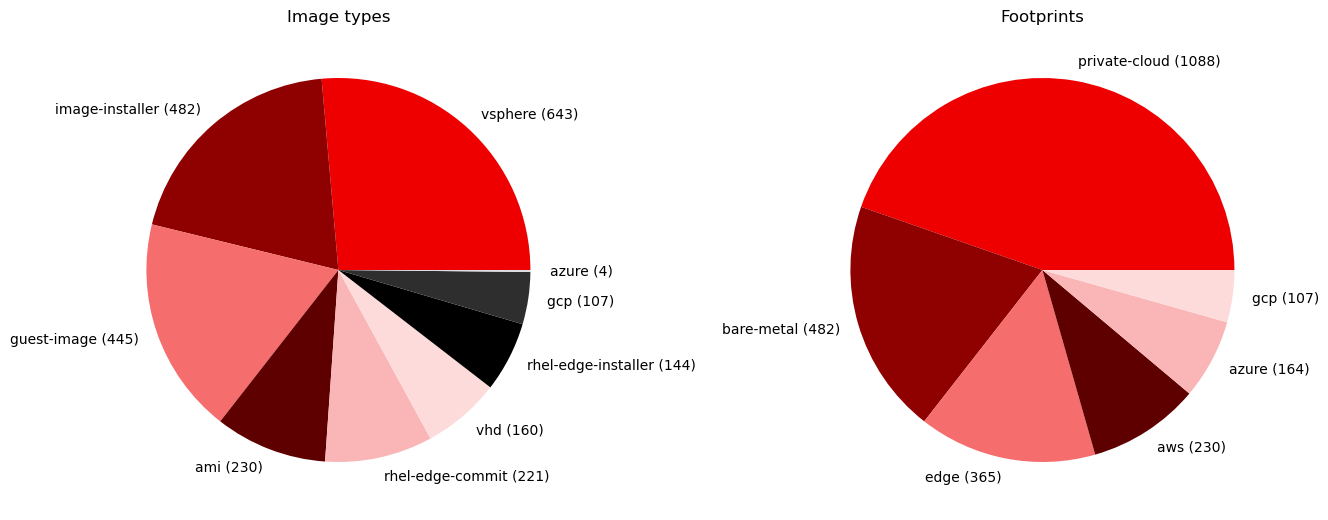

In [6]:
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, 1])
ib.plot.imagetype_builds(builds, ax1)
ax1.set_title("Image types")

ax2 = fig.add_axes([1.1, 0, 1, 1])
ib.plot.footprint_builds(builds, ax2)
ax2.set_title("Footprints")

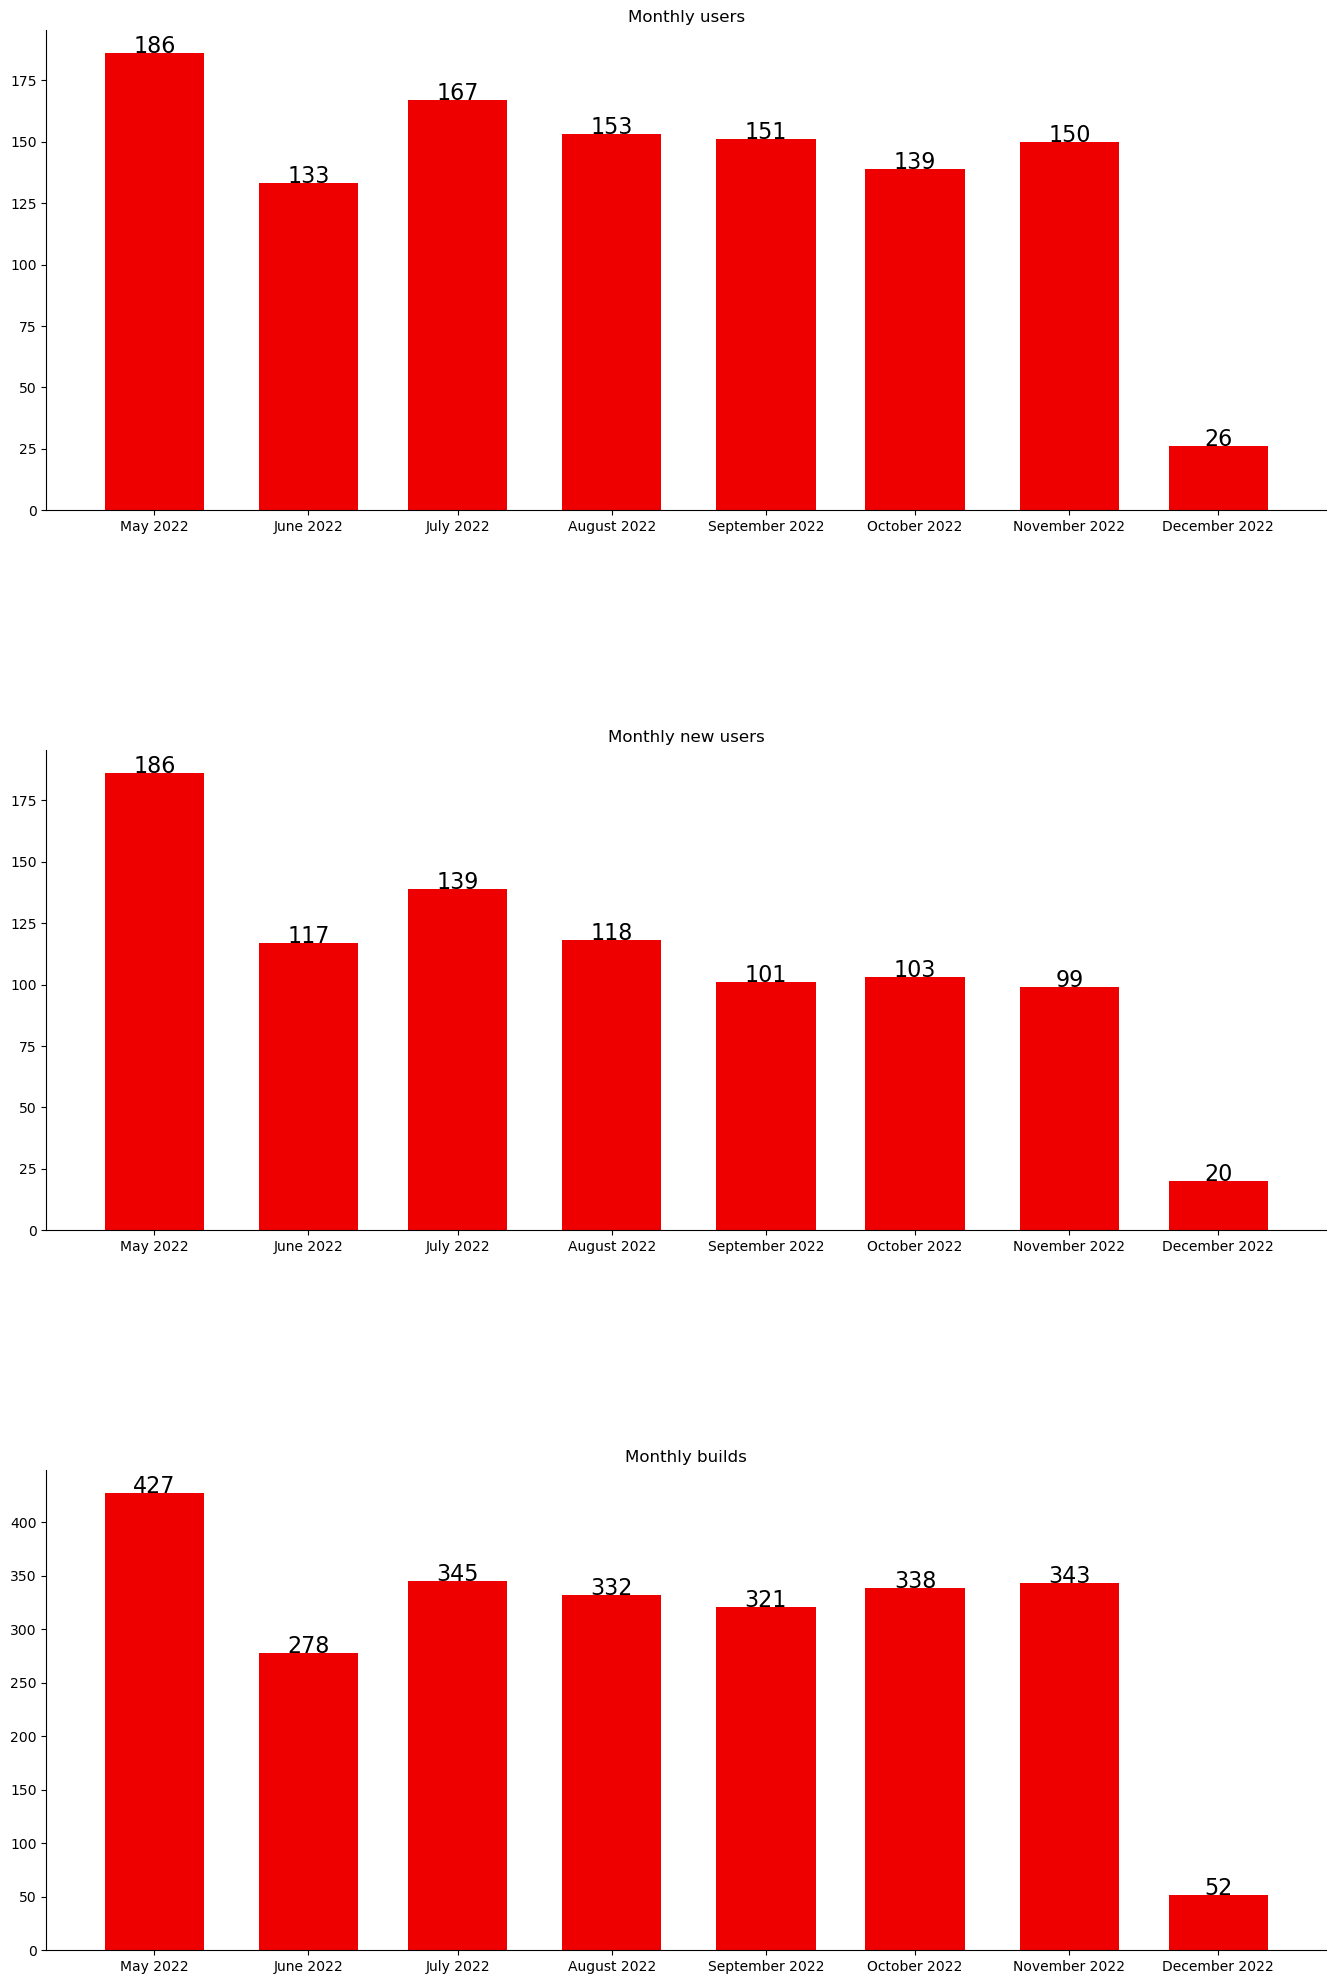

In [7]:
# draw bar graphs again on one figure for convenience
fig = plt.figure()
users_ax = fig.add_axes([0, 3, 2, 1])
ib.plot.monthly_users(builds, users_ax)

new_users_ax = fig.add_axes([0, 1.5, 2, 1])
ib.plot.monthly_new_users(builds, new_users_ax)

builds_ax = fig.add_axes([0, 0, 2, 1])
ib.plot.monthly_builds(builds, builds_ax)

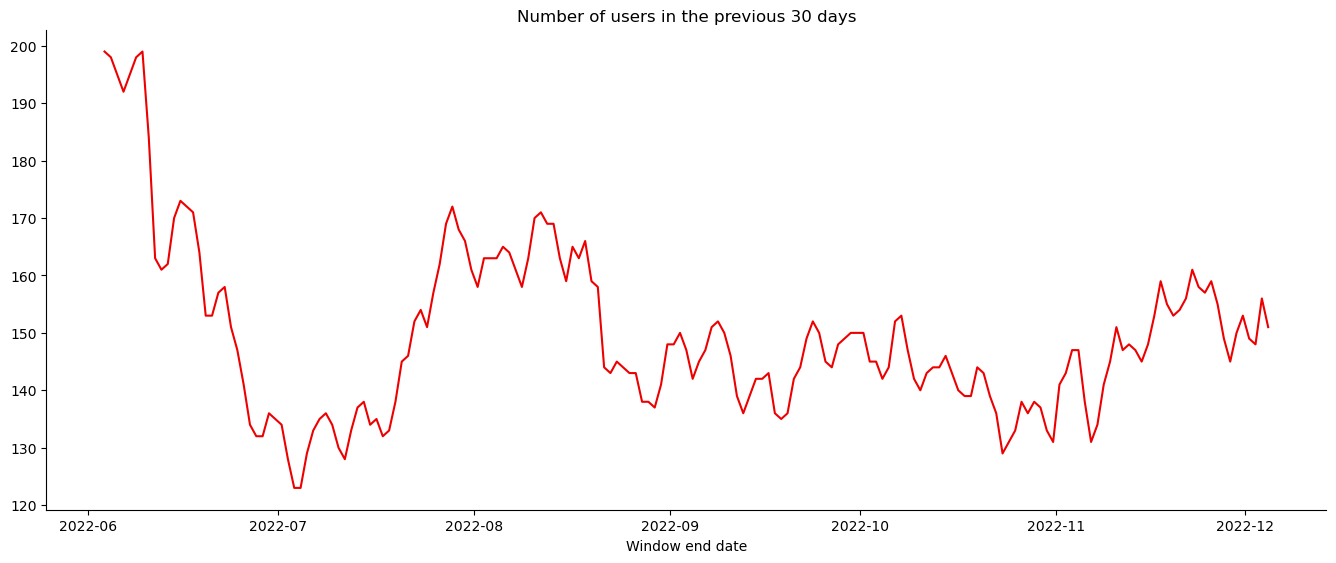

In [8]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 1])
ib.plot.users_sliding_window(builds, ax)

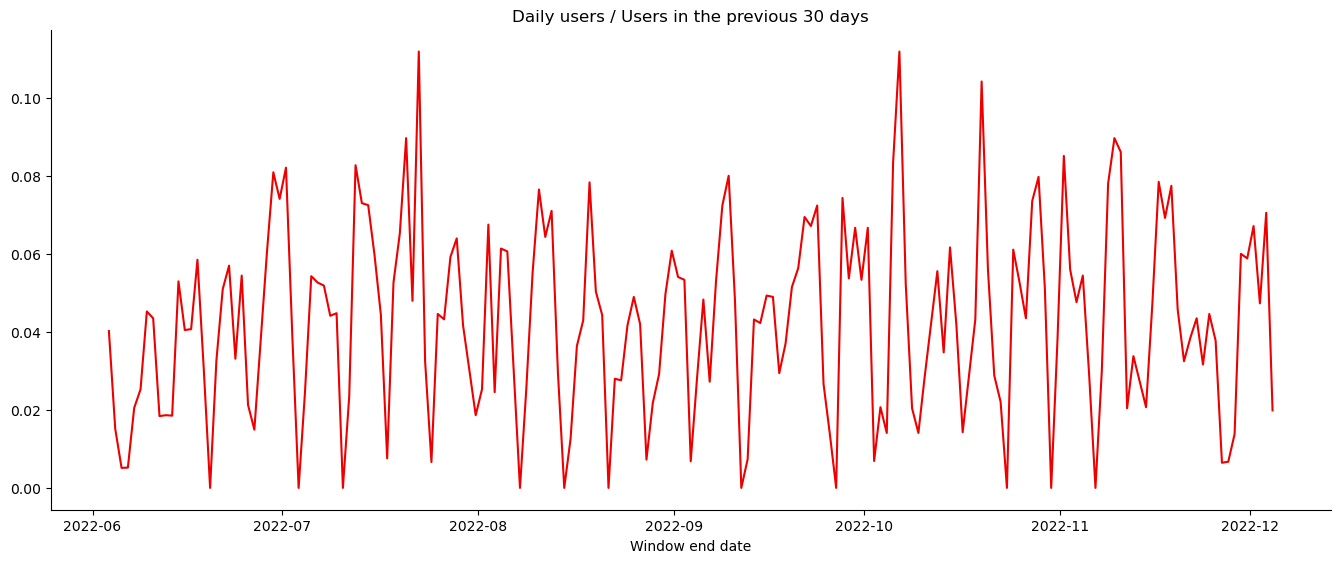

In [9]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 1])
ib.plot.dau_over_mau(builds, ax)

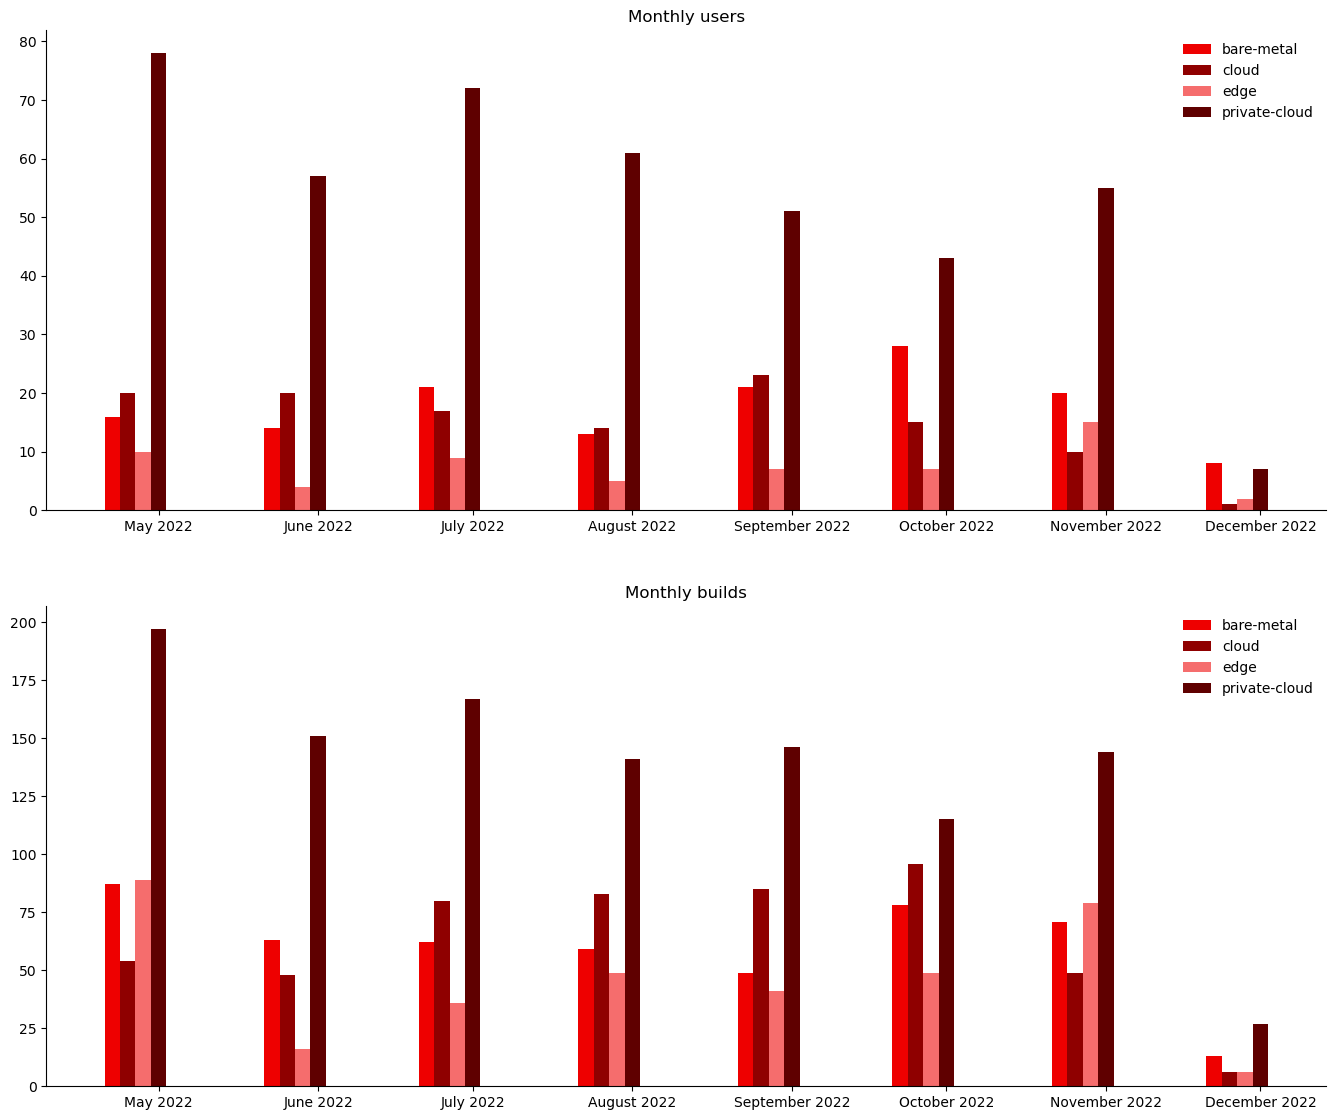

In [10]:
fig = plt.figure()

# single-footprint users: footprints per month
ax1 = plt.axes([0, 1.2, 2, 1])
ib.plot.single_footprint_monthly_users(builds, ax1)

# footprint builds per month
ax2 = plt.axes([0, 0, 2, 1])
ib.plot.footprint_monthly_builds(builds, ax2)

In [11]:
# separate builds for "edge" types
edge_idxs = builds["image_type"].str.contains("edge")
edge_builds = builds.loc[edge_idxs]
non_edge_builds = builds.loc[-edge_idxs]

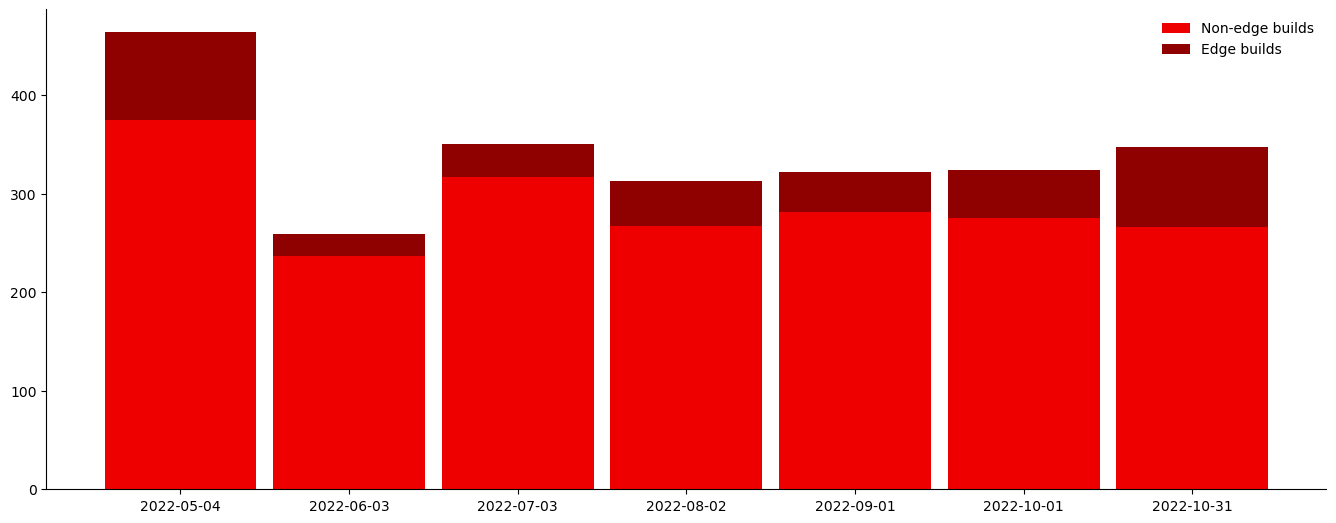

In [12]:
# builds per 7-day period for edge vs non-edge
plt.figure()
ax = plt.axes([0, 0, 2, 1])
width=30
p_days = timedelta(days=width)

e_starts, eb = ib.metrics.builds_over_time(edge_builds, p_days)
ne_starts, ne = ib.metrics.builds_over_time(non_edge_builds, p_days)

ax.bar(ne_starts, ne, width=width*.9, label="Non-edge builds")
ax.bar(ne_starts, eb, bottom=ne, width=width*.9, label="Edge builds")
ax.set_xticks(ne_starts)

ax.legend()

In [13]:
# Separate *users* based on edge vs non-edge
# If any user builds at least one edge image, put all their builds in the edge bucket
edge_users = edge_builds["org_id"].unique()
all_users = builds["org_id"].unique()
non_edge_users = np.setdiff1d(all_users, edge_users)
print(f"Number of edge users*:    {len(edge_users):4d}")
print(f"Number of non-edge users: {len(non_edge_users):4d}")
print(f"Total users:              {len(all_users):4d}")
print('(* "edge user" is any user that has ever built at least a single edge image)')

assert len(edge_users) + len(non_edge_users) == len(all_users)

Number of edge users*:      78
Number of non-edge users:  805
Total users:               883
(* "edge user" is any user that has ever built at least a single edge image)


In [14]:
# Separate builds based on edge-tagged users
edge_user_builds_idxs = builds["org_id"].isin(edge_users)
edge_user_builds = builds.loc[edge_user_builds_idxs]
non_edge_user_builds_idxs = builds["org_id"].isin(non_edge_users)
non_edge_user_builds = builds.loc[non_edge_user_builds_idxs]

print(f"Number of builds from edge users*:    {len(edge_user_builds):4d}")
print(f"Number of builds from non-edge users: {len(non_edge_user_builds):4d}")
print(f"Total builds:                         {len(builds):4d}")
print('(* "edge user" is any user that has ever built at least a single edge image)')

assert len(edge_user_builds) + len(non_edge_user_builds) == len(builds)

Number of builds from edge users*:     481
Number of builds from non-edge users: 1955
Total builds:                         2436
(* "edge user" is any user that has ever built at least a single edge image)


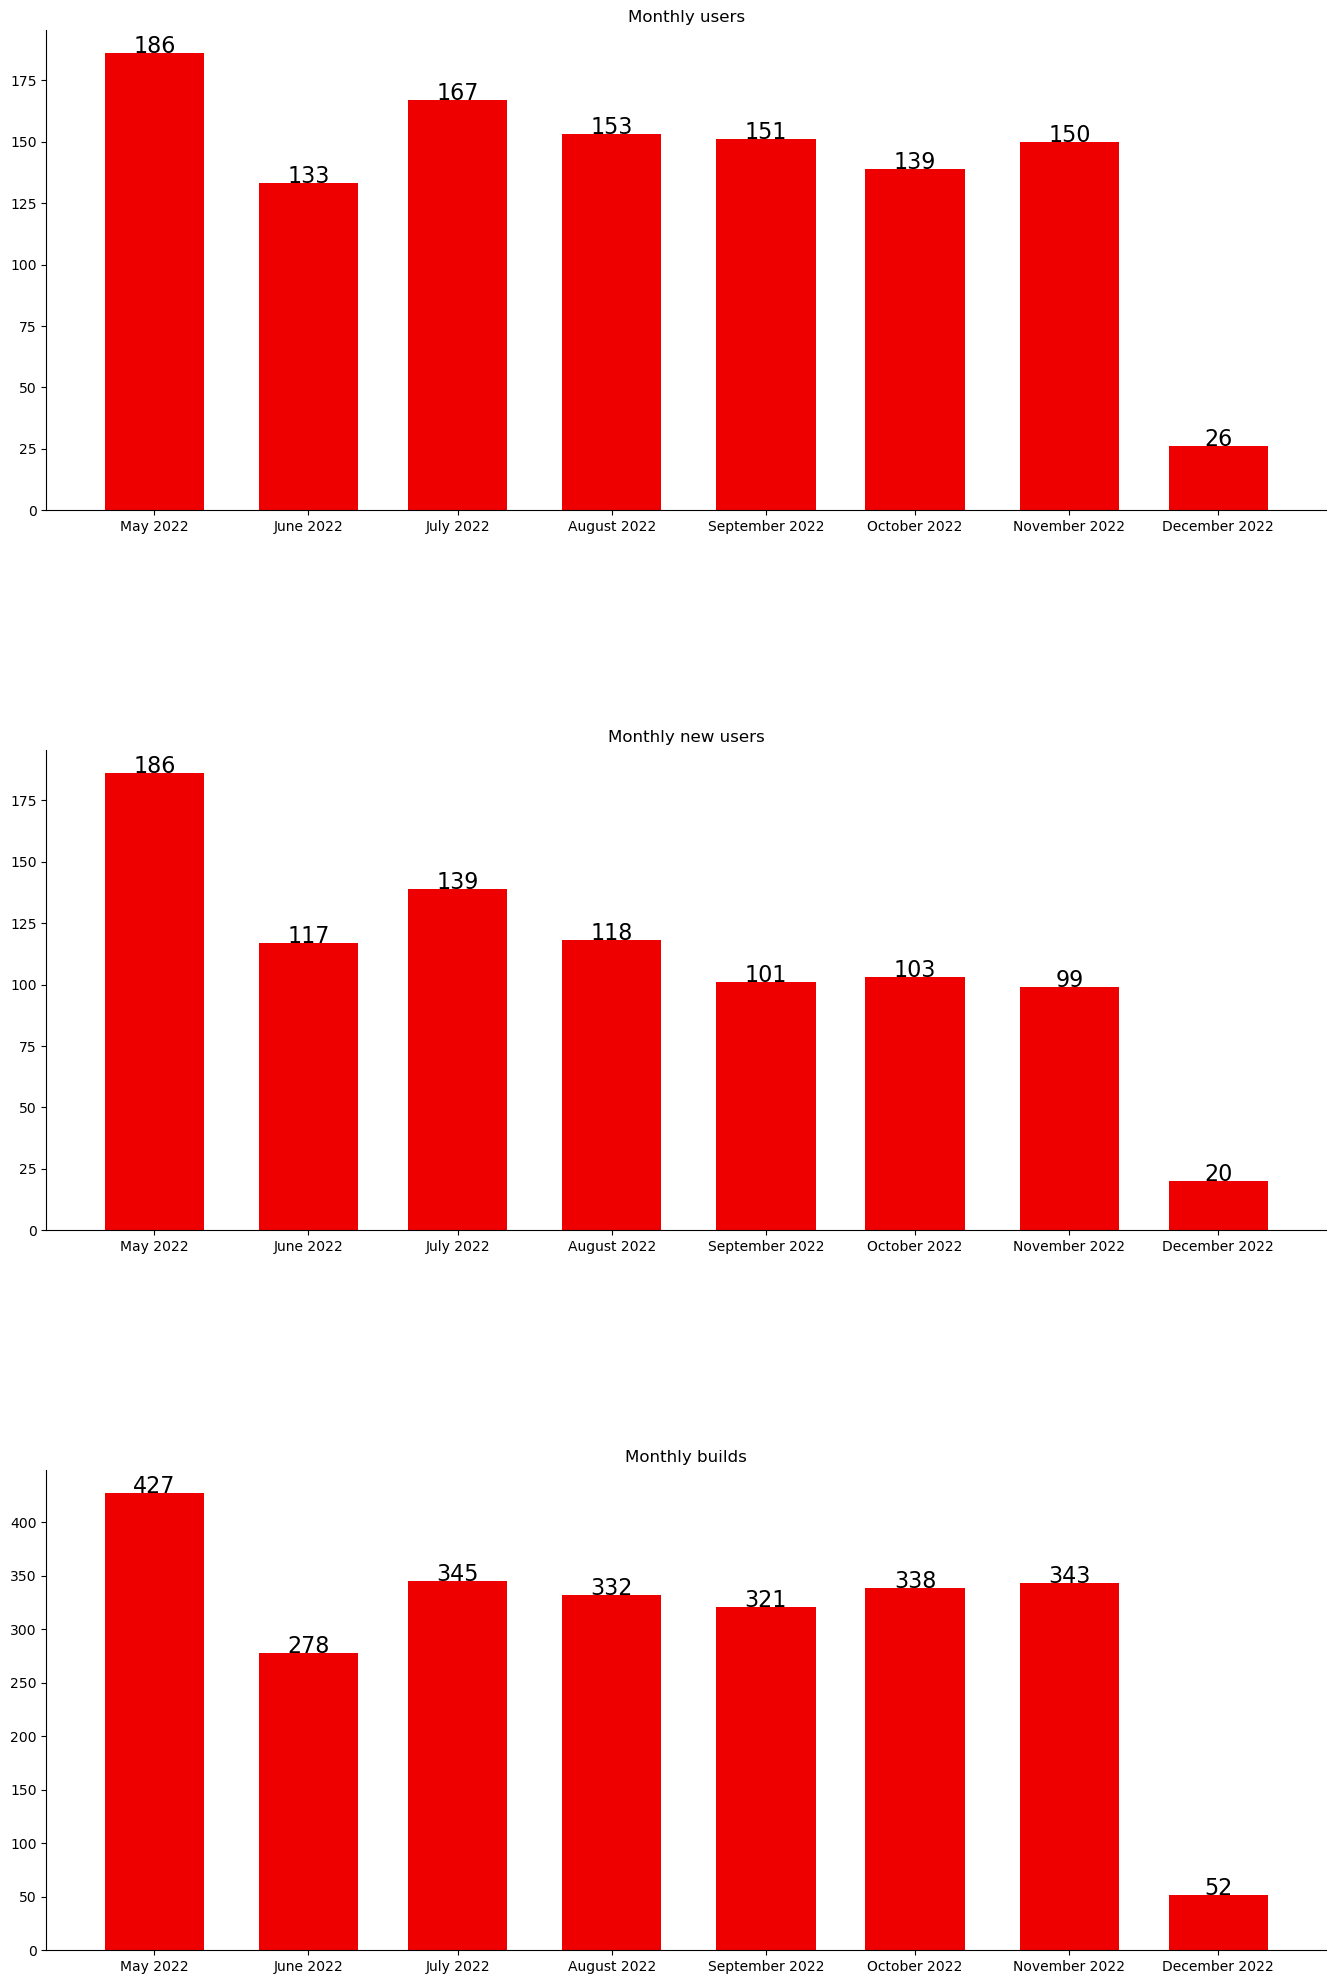

In [15]:
# draw bar graphs again on one figure for convenience
fig = plt.figure()
users_ax = fig.add_axes([0, 3, 2, 1])
ib.plot.monthly_users(builds, users_ax)

new_users_ax = fig.add_axes([0, 1.5, 2, 1])
ib.plot.monthly_new_users(builds, new_users_ax)

builds_ax = fig.add_axes([0, 0, 2, 1])
ib.plot.monthly_builds(builds, builds_ax)